In [2]:
%matplotlib inline

# Modelling Bernoulli Mixture Models with Dirichlet Processes

I've been spending a lot of time over the last week ~~getting Theano working on Windows~~ playing with Dirichlet Processes for clustering binary data using `PyMC3`. While there is a great [tutorial for mixtures of univariate distributions](https://docs.pymc.io/notebooks/dp_mix.html), there isn't a lot out there for multivariate mixtures, and Bernoulli mixtures in particular.

This notebook shows an example of fitting such a model using PyMC3 and highlights the importance of careful parameterisation as well as demonstrating that variational inference can prove advantageous over standard sampling methods like NUTS for such problems.

## Dirichlet Processes

I'm not going to cover Dirichlet Processes in much detail as there are some very useful resources out there already (for example [this tutorial](https://www.cs.cmu.edu/~kbe/dp_tutorial.pdf) or [Teh's original paper](http://www.stats.ox.ac.uk/~teh/research/npbayes/Teh2010a.pdf)).

In short, however, mixture modelling provides a formal way of identifying clusters or groups in data by specifying a latent model structure that can be parameterised using the observed data.
Conventional clustering methods, such as hierarchical clustering, non-negative matrix factorisation, k-means, density scan, etc... are useful for a quick exploratory analysis, but the lack of a formal model can be a limitation, particularly when classifying new cases is a requirement.

The density of a data point $X_i$ is the weighted sum of the densities from each of the $K$ components, parameterised by distribution parameters $\theta_k$ and mixing weight $\pi_k$.

$$f(X_i) = \sum^K_{k=1} \pi_k f(X_i | \theta_k)$$

A conventional mixture model requires the number of clusters $K$ to be specified in advance, and are termed _finite mixture models_. These models can be fit in a likelihood (using Expectation-Maximisation) or Bayesian setting (using MCMC), where the optimal value of $K$ can be found through means such as likelihood measures or treating $K$ as a random variable in a Bayesian setting.

Rather than specifying $K$, or treating it as a random variable, _non-parametric mixed models_ let $K \to \infty$ and grows with the data. There are still parameters that define the model (mixture weights and variable coefficients), but there are now an infinite number of them, hence non-parametric, however, only a finite number will provide significant contributions.
Using the stick-breaking construction, a Dirichlet Process provides a prior for an infinite $K$ as follows:

$$G \sim \text{DP}(\alpha, G_0)$$
$$\theta_k \sim G_0$$
$$\beta_k \sim \text{Beta}(1, \alpha)$$
$$\pi_k = \beta_k\prod_{j=1}^{k-1} (1 - \beta_j)$$

Where $\alpha$ is a concentration parameter, $G_0$ is the _base distribution_.


## Simulated dataset

Let's firstly setup the environment and create a simulated dataset of 1000 observations of 5 binary variables, belonging to 3 groups with different rates.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

N = 1000
P = 5

# Simulate 5 variables with 1000 observations of each that fit into 3 groups
theta_actual = np.array([[0.7, 0.8, 0.2, 0.1, 0.1],
                      [0.3, 0.5, 0.9, 0.8, 0.6],
                      [0.1, 0.2, 0.5, 0.4, 0.9]])
cluster_ratios = [0.4, 0.3, 0.3]  

df = np.concatenate([np.random.binomial(1, theta_actual[0, :], size=(int(N*cluster_ratios[0]), P)),
                     np.random.binomial(1, theta_actual[1, :], size=(int(N*cluster_ratios[1]), P)),
                     np.random.binomial(1, theta_actual[2, :], size=(int(N*cluster_ratios[2]), P))])
df[1:10, :]

array([[1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [4]:
df.shape

(1000, 5)

## Mixture model specification

Now let's setup the Dirichlet Process, firstly importing Theano and PyMC3.

In [5]:
from theano import tensor as tt
import pymc3 as pm

As in the above tutorial, we'll be using the stick-breaking method (Sethuraman 1994) to perform draws from G.

In [6]:
# Deterministic function for stick breaking
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

The following snippet defines the model, which fairly simply computes the DP prior on $\pi_k$, as well as providing a prior on the Bernoulli parameters $\theta_k$ from the base distribution $G_0$.

Note the definition of $K=30$. This isn't forcing a finite mixture model with 30 clusters, but rather it is an approximation $K\to\infty$ due to the stick-breaking method, provided it is much bigger than the expected number of clusters.

The next lines deal with the mixture model itself, using the `Mixture` distribution provided in `PyMC3`. Getting this to work with multivariate distributions requires careful setting of the shapes, ensuring that the last dimension of the mixture distributions is the cluster that is being mixed over.

Also note the hack to get this working with 2D observations pointed out by [lucianopaz on my dicourse issue](https://discourse.pymc.io/t/mixture-of-multivariate-bernoullis/2611/2), by adding an additional dimension.

In [7]:
K = 30

with pm.Model() as model:
    # The DP priors to obtain w, the cluster weights
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    # Prior on Bernoulli parameters, use Jeffrey's conjugate-prior
    theta = pm.Beta('theta', 0.5, 0.5, shape=(P, K))

    obs = pm.Mixture('obs', w, 
                     pm.Bernoulli.dist(theta, shape=(P, K)),
                     shape=(P,1),
                     observed=np.expand_dims(df, axis=2))  # Add 3rd dimension to observations, required for 2D mixture

Let's sample from this with NUTS under the default settings, which takes 23 minutes to sample 1000 times (2 chains are running in parallel).

In [6]:
with model:
    trace = pm.sample(random_seed=17)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [23:38<00:00,  1.09s/draws]
There were 188 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9128847816642831, but should be close to 0.8. Try to increase the number of tuning steps.
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


The convergence doesn't look great, this could benefit from taking more samples and tweaking the NUTS parameters to improve convergence, but given how long it took for 1,000 samples I'm not keen to run it for any longer!

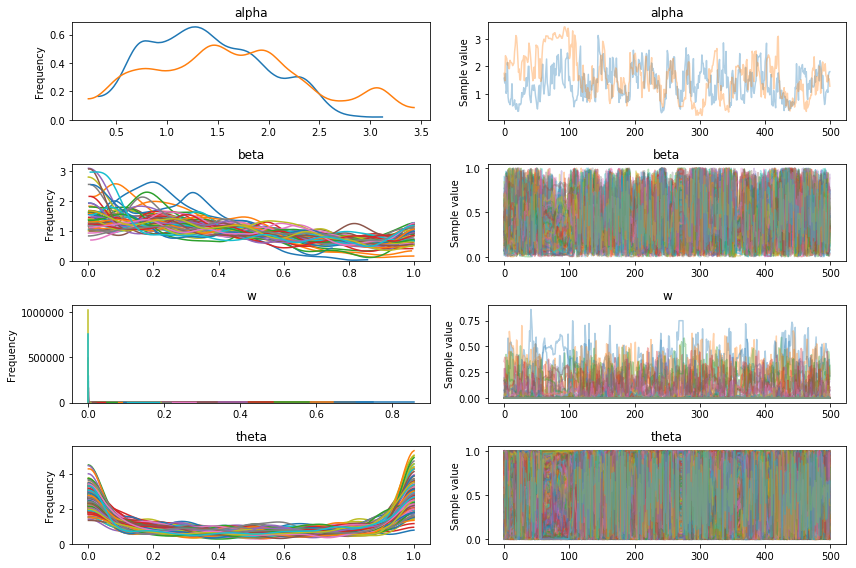

In [7]:
pm.traceplot(trace);

This plot shows the weights for each component, which look very similar to the stick-breaking prior so it really doesn't seem like the sampling managed to find the mixture structure.

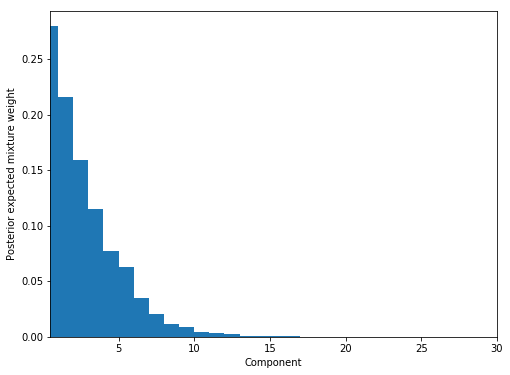

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1
ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);
ax.set_xlim(0.5, K);
ax.set_xlabel('Component');
ax.set_ylabel('Posterior expected mixture weight');

## Manually calculating density

Let's try optimising this sampler, firstly by reparameterising the model.
While the PyMC3 `Mixture` class is very useful and handles the calculation of the mixture density from an arbitrary number of mixtures from potentially different distribution families, in the case of a Bernoulli mixture the likelihood is actually very straightforward to compute and providing it ourselves could result in a speed-up.

Remember that the density is as follows:

$$f(X_i) = \sum^K_{k=1} \pi_k f(X_i | \theta_k)$$

Where each cluster follows the standard Bernoulli density:

$$f(X_i | \theta_k) = \prod_{d=1}^{D} \theta_{kd} ^ {X_{id}} (1-\theta_{kd}) ^ {1-X_{id}}$$

This is more easily calculated by drawing a discrete component for each obseration according to $\pi$:

$$c_i \sim \text{Categorical}(\pi)$$
$$f(X_i) = f(X_i | \theta_k, c_i = k)$$

**However, sampling discrete parameters cannot be done using NUTS and is extremely slow using Gibbs**, which is partly one of the benefits of the `Mixture` class as it marginalizes $c$ out for us.

But again, given how simple the (log) Bernoulli density is we may as well do the marginalising ourselves, resulting in the implementation below.
Note that it has been **heavily vectorised**, providing an additional speed increase by using the highly efficient MKL linear algebra libraries.

In [8]:
def bernoulli_loglh(theta, weights):
    def _logp(value):
        value_neg = 1 - value
        logtheta = tt.log(theta)
        neglogtheta = tt.log(1-theta)

        # N*K matrix of likelihood contributions from X_i with mu_k
        betas = tt.tensordot(value, logtheta, axes=[1, 1]) + tt.tensordot(value_neg, neglogtheta, axes=[1, 1])

        ## Form alphas, NxK matrix with the component weights included
        alphas = (betas + tt.log(weights)).T

        # Take LSE rowise to get N vector
        # and add alpha_cluster1 to get the total likelihood across all
        # components for each X_i
        lse_clust = pm.math.logsumexp(alphas - alphas[0, :], axis=0) + alphas[0,:]

        # Final overall sum
        return tt.sum(lse_clust)
    return _logp

This custom density is used in a `DensityDist` distribution. 

In [9]:
with pm.Model() as model:
    # The DP priors to obtain w, the cluster weights
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    theta = pm.Beta('theta', 1, 1, shape=(K, P))
    obs = pm.DensityDist('obs', bernoulli_loglh(theta, w),
                         observed=df)

Notice how much quicker this is with the same NUTS setup taking 3 minutes: a 7.6x speed increase over the built-in `Mixture` distribution! However, there are still convergence issues: there is high Gelman-Rubin, warnings about divergences following tuning, and the traces appear to have poor mixing (for alpha at least, it's hard to tell for the other traces with more variables).

In [11]:
with model:
    trace2 = pm.sample(random_seed=17)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [03:44<00:00,  6.34draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


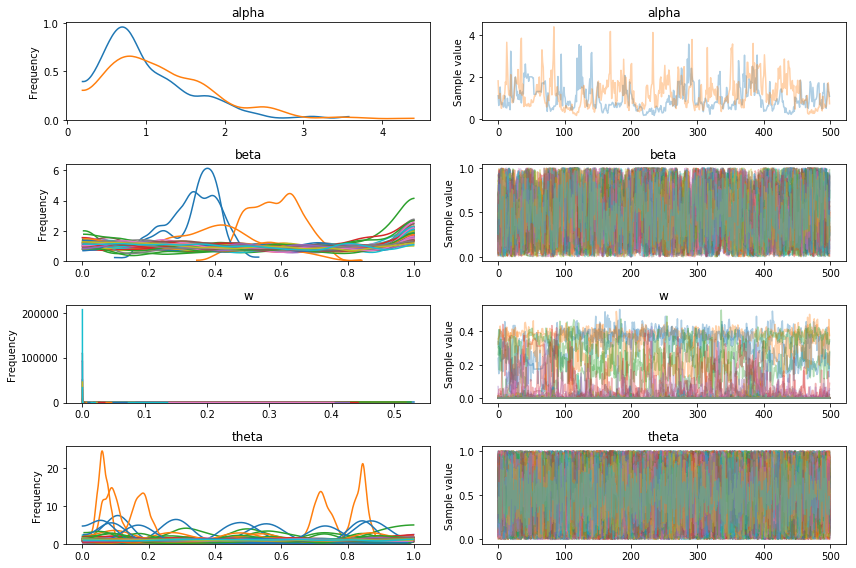

In [12]:
pm.traceplot(trace2);

But, due to the quicker sampling we can take steps to improve the convergence:

  - taking more samples
  - increase the tuning length
  - raise the target acceptance rate as suggested in the log above
  
The resulting traces look much better, but we're still getting warnings about divergences, and the components plot below suggests that the model hasn't identified the true 3 clusters.

In [13]:
with model:
    trace3 = pm.sample(10000, 
                      random_seed=17, 
                      tune=1000,
                      nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, beta, alpha]
Sampling 2 chains: 100%|██████████| 22000/22000 [49:30<00:00,  6.34draws/s]  
There were 289 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8018979356112526, but should be close to 0.9. Try to increase the number of tuning steps.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


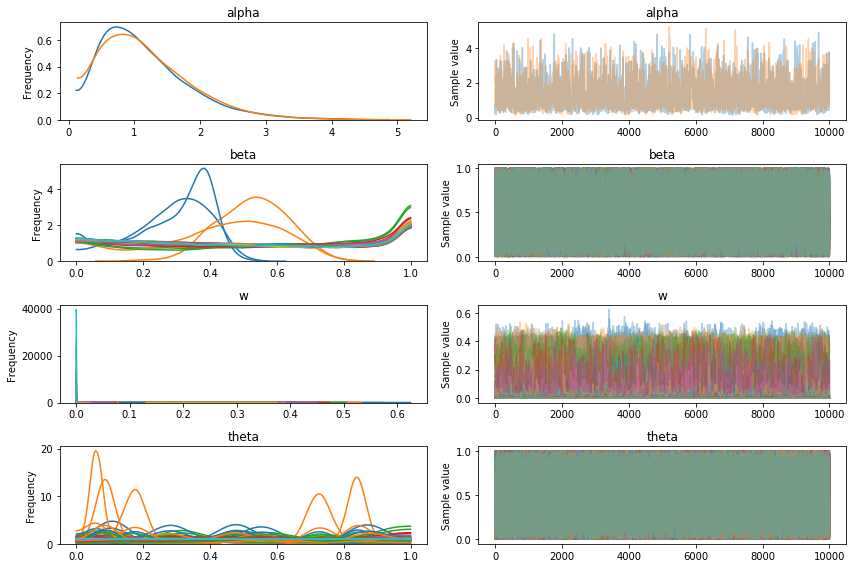

In [14]:
pm.traceplot(trace3);

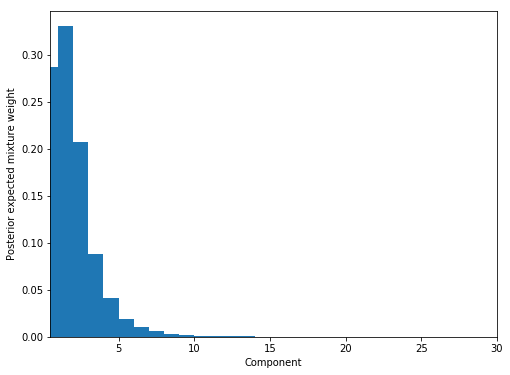

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1
ax.bar(plot_w - 0.5, trace3['w'].mean(axis=0), width=1., lw=0);
ax.set_xlim(0.5, K);
ax.set_xlabel('Component');
ax.set_ylabel('Posterior expected mixture weight');

## Variational Inference

At this point we could try tweaking NUTS more, but at 45 minutes a run this will take a while and even with 10,000 samples it was clearly struggling with this model.

I now take a different approach and use variational inference. Rather than sampling using a MCMC chain, variational inference treats the parameter fitting as an optimisation task to minimise the Kullback-Liebler divergence. It does not guarantee to convergence on the true posterior in the same way that MCMC does, but that is still dependent upon the MCMC assumptions being met.

It can be far more computationally efficient but this comes at the cost of inaccuracy and the lack of guarantee of sampling the true posterior. However, for complex models it can be a useful tool and allows you to check your model specification is correct without the time-consuming process of tuning the sampling. 
The lack of guarantee of convergence is less of a concern for clustering where it is typically employed as more of a data exploration tool rather than a method for drawing inference.

Running the default VI implementation (ADVI) in PyMC3 is very efficient, taking only 30 seconds on this relatively complex model on a medium size dataset. Sampling from it shows slightly worse mixing than we had with the longer NUTS run, so let's bump up both the number of ADVI iterations and the number of samples.

In [16]:
with model:
    vi_fit = pm.fit(method='advi')
trace4 = vi_fit.sample()

Average Loss = 3,247.1: 100%|██████████| 10000/10000 [00:31<00:00, 314.93it/s]
Finished [100%]: Average Loss = 3,246.8


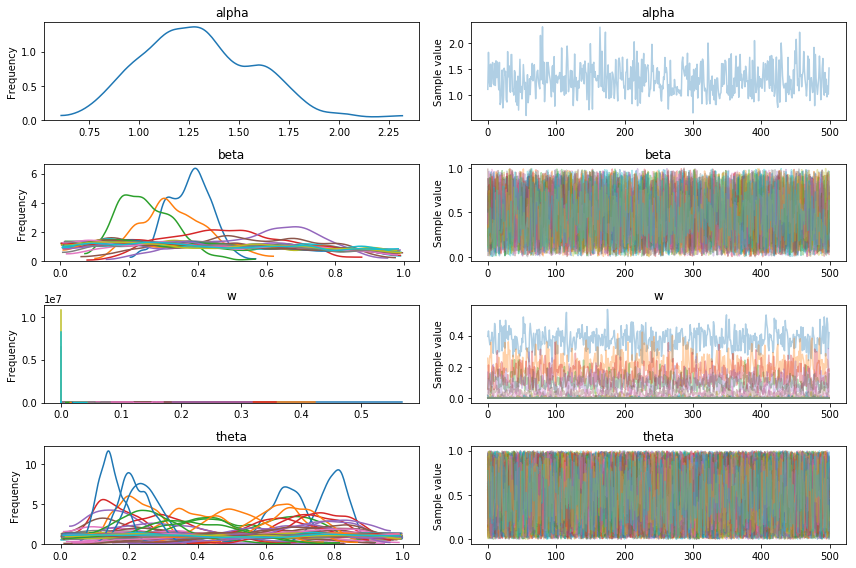

In [17]:
pm.traceplot(trace4);

I've increased the number of ADVI iterations by tenfold, but the loss stopped decreasing around 30,000. However, this stilll only took 5 minutes.

The traces look _much_ better, and note how there are 3 distinct non-zero betas, suggesting it has found the 3 components. 

In [10]:
with model:
    vi_fit2 = pm.fit(method='advi', n=100000)
trace5 = vi_fit2.sample(10000)

Average Loss = 3,200.6: 100%|██████████| 100000/100000 [05:08<00:00, 324.53it/s]
Finished [100%]: Average Loss = 3,200.6


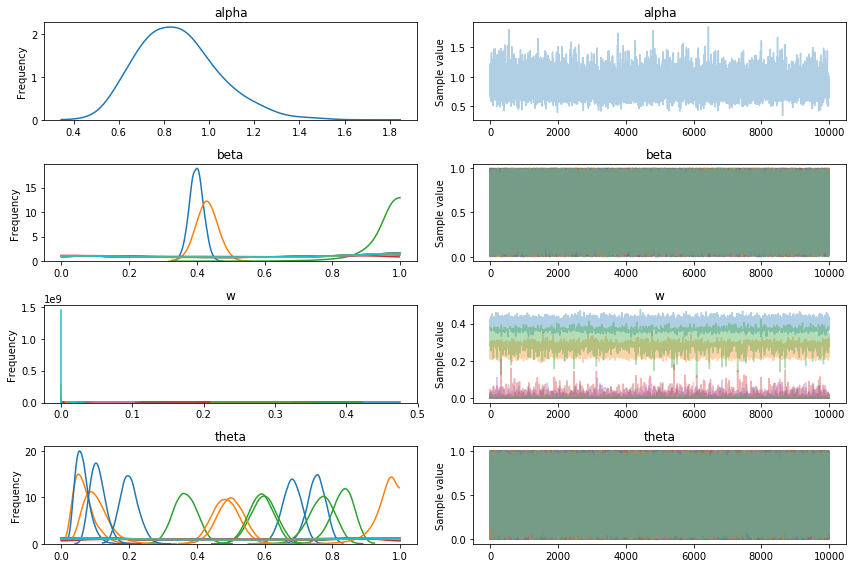

In [11]:
pm.traceplot(trace5);

Looking at the expected mixture weight and it definitely seems like it has identified 3 clusters in the data and no more (note that if you are struggling to find the number of clusters try increasing K so that it is much larger than the expected number of groups).

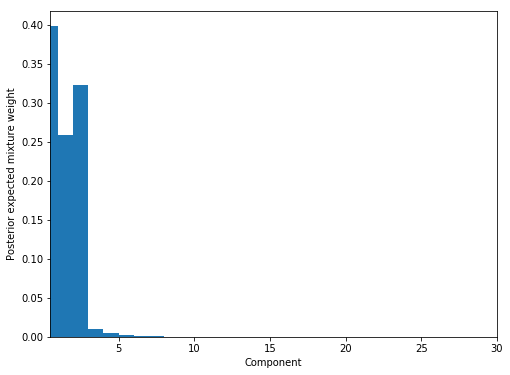

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1
ax.bar(plot_w - 0.5, trace5['w'].mean(axis=0), width=1., lw=0);
ax.set_xlim(0.5, K);
ax.set_xlabel('Component');
ax.set_ylabel('Posterior expected mixture weight');

Let's inspect the coefficients from these components. Firstly I pick out the non-zero components (defined as $\pi_k > 0.1$), and then inspect the $\theta_k$, which are vectors of length 5 corresponding to the 5 simulated variables.

I've displayed the actual parameters used to generate the data below and we can see that the model has clearly identified these components (row 1 in model corresponds to row 1 of actual, 2 to 3, and 3 to 2). 

In [13]:
mean_w = np.mean(trace5['w'], axis=0)
nonzero_component = np.where(mean_w > 0.1)[0]

mean_theta = np.mean(trace5['theta'], axis=0)
print(mean_theta[nonzero_component, :])

[[0.68041937 0.75237926 0.20082285 0.06283251 0.10812686]
 [0.06701944 0.10312048 0.50042289 0.4843502  0.95220014]
 [0.36629062 0.59693106 0.82948815 0.76710145 0.58927039]]


In [14]:
theta_actual

array([[0.7, 0.8, 0.2, 0.1, 0.1],
       [0.3, 0.5, 0.9, 0.8, 0.6],
       [0.1, 0.2, 0.5, 0.4, 0.9]])

## Summary

This has been a quick summary of fitting Dirichlet Process Bernoulli Mixture Models in PyMC3 with the following take home messages:

  - The `Mixture` class requires careful consideration of the component distributions' shapes when fitting, and may need an extra dimension hacked onto observed data for multi-variate case
  - Writing your own log-probability function can provide substantial speed ups, provided it is suitably vectorised
  - Variational Inference offers a fast approximation of the posterior and can be particularly attractive for mixture models. For this simulated dataset it was far more successful than NUTS in identifying the mixture components and and was far quicker
  
I would like to point out that this is very much a demonstrative example; for any serious model I'd perform rigorous diagnostics and would try to get NUTS working instead. I haven't used Variational Inference before but I've seen [this paper by Andrew Gelman's group](https://arxiv.org/pdf/1802.02538.pdf) that identifies diagnostic strategies for assessing goodness-of-fit.

Also while this approach worked for this clean simulated dataset, I could not easily get such a good fit for my noisy real-world dataset. If I had more time I would write my own Gibbs sampler, following [Radford Neal's excellent discussion of them for Dirichlet Processes](http://www.stat.columbia.edu/npbayes/papers/neal_sampling.pdf), rather than using a general purpose off-the-shelf implementation like I'm doing here with NUTS.